In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import numpy as np
import os,sys
import matplotlib.pyplot as plt
import netCDF4 as cdf 
from tm5tools import globarea
from matplotlib.pyplot import *
from maptools import select_map
import calendar
import datetime as dt
from __future__ import division
import csv

In [3]:
biofireparamdirs = [
'/Storage/CO2/carbontracker/input/ctdas_2012/biosphere/gfed4_daily_sibcasa_3hr/',
'/Storage/CO2/carbontracker/input/ctdas_2012/biosphere/gfed4_daily_sibcasa_3hr_gfas_fires/',
'/Storage/CO2/carbontracker/input/ctdas_2012/biosphere/gfed4_daily_sibcasa_3hr_finn_fires/', #FINN
'/Storage/CO2/carbontracker/input/ctdas_2012/biosphere/casa-gfed4-daily-fires-monthly-bio/'#CASA-GFED4 fires daily
]

lbls  = ['SiBCASA-GFED4', 'GFAS', 'FINN', 'CASA-GFED4']

In [4]:
glarea2 = globarea(im=360,jm=180)
fac1 = 12*24*60*60 #mol/m2/s -> gC/m2/day
fac2 = 12*24*60*60*365*1e-15 #mol/m2/s -> PgC/m2/yr
lons=np.arange(-179.5,180,1)
lats=np.arange(-89.5,90,1)
#Mask
f = cdf.Dataset('/Storage/CO2/carbontracker/input/ctdas_2012/regions_sibcasa_koppen_sam.nc')
tc = f.variables['transcom_regions'][:]
f.close()
sam = tc
index = np.where(sam <> 3)
sam[index] = 0
index = np.where(sam <> 0)
sam[index] = 1
mf = cdf.Dataset('/Users/botia/daily_fires/amazon_mask.nc')
mask = mf.variables['regionmask'][:]

In [5]:
def make_map(fill_color = True):
    m,nx,ny = select_map('South America Albers')
    m.drawcoastlines(color='grey',linewidth=0.5)
    m.drawcountries(color='grey',linewidth=0.5) 
    if fill_color:
        m.drawmapboundary(fill_color='#d8d8d8')
        m.drawparallels(np.arange(-90,91,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,0],fontsize=13)
        m.drawmeridians(np.arange(-180,180,15),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,0],fontsize=13)
    return m,nx,ny

In [6]:
################################### Fire Emissions Spatial Distribution ####################################################

minyear = 2010
maxyear = 2016

fig = plt.figure(1,figsize=(8,12))

bb_yravg_sibcasa = np.zeros((6,180,360),float)
bb_yravg_gfas    = np.zeros((6,180,360),float)
bb_yravg_finn    = np.zeros((6,180,360),float)
bb_yravg_casa    = np.zeros((6,180,360),float)

for ii,dirbf in enumerate(biofireparamdirs):
    alltimes = []
    allbb    = []
    cont     = 0
    print dirbf
    for y in range(minyear,maxyear):
        #print y
        for fname in os.listdir(dirbf):
            
            if fname.startswith('READ'): continue
            if not int(fname[-9:-5]) == y: continue
            bf = cdf.Dataset(dirbf+fname)
            if 'co2fire' in bf.variables.keys():
                bb = np.float32(bf.variables['co2fire'][:])
            else: 
                bb = bf.variables['bb'][:]
            if bb.shape[0] == 180: #add time dimension
                bb.resize(1,180,360)  
            try: 
                bb[bb.mask] = 0
                bb = np.array(bb)
            except: pass    
            if int(fname[-5:-3]) == 1: 
                bb_sum = bb
            else: bb_sum = np.append(bb_sum,bb,axis=0) 
            bf.close()
        
        bb_sum  = bb_sum.mean(axis=0)
        #bb_year = np.ma.masked_where(sam == 0,bb_sum)
        #print ii,cont
        if ii == 0: bb_yravg_sibcasa[cont] = bb_sum
        if ii == 1: bb_yravg_gfas[cont]    = bb_sum
        if ii == 2: bb_yravg_finn[cont]    = bb_sum
        if ii == 3: bb_yravg_casa[cont]    = bb_sum
        cont +=1


/Storage/CO2/carbontracker/input/ctdas_2012/biosphere/gfed4_daily_sibcasa_3hr/
/Storage/CO2/carbontracker/input/ctdas_2012/biosphere/gfed4_daily_sibcasa_3hr_gfas_fires/


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:32: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.


/Storage/CO2/carbontracker/input/ctdas_2012/biosphere/gfed4_daily_sibcasa_3hr_finn_fires/
/Storage/CO2/carbontracker/input/ctdas_2012/biosphere/casa-gfed4-daily-fires-monthly-bio/


<matplotlib.colorbar.Colorbar instance at 0x13511bf38>

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


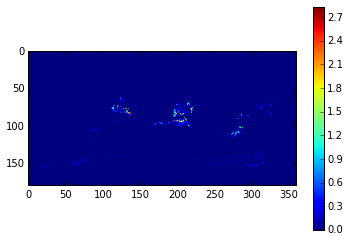

In [7]:
bb_yravg_sibcasa_mean = (bb_yravg_sibcasa*fac1).mean(axis=0)
bb_yravg_gfas_mean    = (bb_yravg_gfas*fac1).mean(axis=0)
bb_yravg_finn_mean    = (bb_yravg_finn*fac1).mean(axis=0)
bb_yravg_casa_mean    = (bb_yravg_casa*fac1).mean(axis=0)

imshow(bb_yravg_sibcasa_mean)
colorbar()

In [8]:
#Spatial Analysis
sibcasa_gfas = bb_yravg_sibcasa_mean / (bb_yravg_sibcasa_mean + bb_yravg_gfas_mean)
sibcasa_finn = bb_yravg_sibcasa_mean / (bb_yravg_sibcasa_mean + bb_yravg_finn_mean)
sibcasa_casa = bb_yravg_sibcasa_mean / (bb_yravg_sibcasa_mean + bb_yravg_casa_mean)
type(sibcasa_gfas)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()
/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


numpy.ndarray

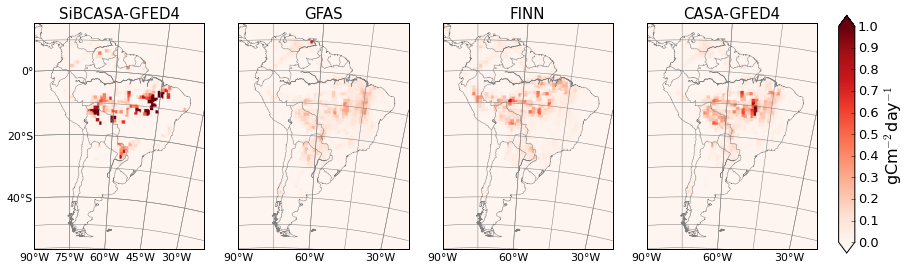

In [9]:
fig = plt.figure(1,figsize=(15,10))

ax1 = plt.subplot2grid((1, 4), (0, 0), colspan=1)
ax1.set_title(lbls[0],fontsize=15)
m,nx,ny = make_map()
m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,15),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
fluxmap = m.transform_scalar((bb_yravg_sibcasa_mean),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap('Reds'),vmin=0,vmax=1)

ax2 = plt.subplot2grid((1, 4), (0, 1), colspan=1)
ax2.set_title(lbls[1],fontsize=15)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
fluxmap = m.transform_scalar((bb_yravg_gfas_mean),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap('Reds'),vmin=0,vmax=1)

ax3 = plt.subplot2grid((1, 4), (0, 2), colspan=1)
ax3.set_title(lbls[2],fontsize=15)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
fluxmap = m.transform_scalar((bb_yravg_finn_mean),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap('Reds'),vmin=0,vmax=1)

ax4 = plt.subplot2grid((1, 4), (0, 3), colspan=1)
ax4.set_title(lbls[3],fontsize=15)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=11)
fluxmap = m.transform_scalar((bb_yravg_casa_mean),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap('Reds'),vmin=0,vmax=1)

fig.subplots_adjust(right=0.85,top=0.9,wspace=0.2,hspace=0.05)
cbar_ax = fig.add_axes([0.87, 0.35, 0.015, 0.33]) # left, bottom, width, height
cbar = fig.colorbar(q, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'gCm$^{-2}$day$^{-1}$', fontsize = 16)
fig.savefig('SpatialDistribution_AvgFire.png',bbox_inches='tight',DPI=1000)
plt.show()
plt.close()

# Mapping differences with other inventories having SiBCASA-GFED4 as reference
- 0.5 indicates that in that pixel both inventories have the same values of C emissions in the 2010-2015 period.
- 1 indicates that sibcasa-gfed4 estimates emissions while the other inventory doesnt showed emissions in all the study period.
- 0 indicates that sibcasa-gfed4 has no emissions for the study period but the other inventory does have reported values

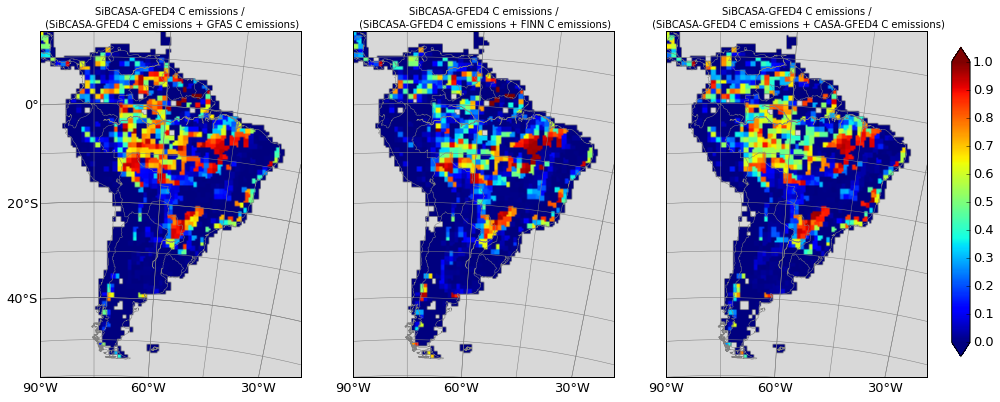

In [18]:
#fig = plt.figure(1,figsize=(15,10))
fig = plt.figure(1,figsize=(17,13))

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax1.set_title('SiBCASA-GFED4 C emissions / \n (SiBCASA-GFED4 C emissions + GFAS C emissions)',fontsize=10)
m,nx,ny = make_map()
m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=13)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=13)
fluxmap = m.transform_scalar((sibcasa_gfas),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap(),vmin=0,vmax=1)

ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=1)
ax2.set_title('SiBCASA-GFED4 C emissions / \n (SiBCASA-GFED4 C emissions + FINN C emissions)',fontsize=10)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=13)
fluxmap = m.transform_scalar((sibcasa_finn),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap(),vmin=0,vmax=1)

ax3 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax3.set_title('SiBCASA-GFED4 C emissions / \n (SiBCASA-GFED4 C emissions + CASA-GFED4 C emissions)',fontsize=10)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=13)
fluxmap = m.transform_scalar((sibcasa_casa),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap(),vmin=0,vmax=1)

fig.subplots_adjust(right=0.85,top=0.9,wspace=0.2,hspace=0.05)
cbar_ax = fig.add_axes([0.87, 0.35, 0.015, 0.33]) # left, bottom, width, height
cbar = fig.colorbar(q, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=13)
#cbar.set_label(r'gCm$^{-2}$day$^{-1}$', fontsize = 16)
fig.savefig('SpatialDistribution_Index.png',bbox_inches='tight',DPI=1000)
plt.show()
plt.close()

In [11]:
## Creating masks
f = cdf.Dataset('/Storage/CO2/carbontracker/input/ctdas_2012/regions_sibcasa_koppen_sam.nc') # assigning to f the dataset from the netcdf file
tc = f.variables['transcom_regions'][:]     #from f the variable transcom_regions is assigned to tc
f.close() 

index = np.where(tc <> 3)           # defines an index for the places where the transcom regions are different than 3
tc[index] = 0                       # everywhere in tc where the index is present (not 3) is equal to zero
index = np.where(tc <> 0)           # a new index to redefine tc
tc[index] = 1                       # everywhere in tc where the index is present, 3, is equal to 1
tc = np.ma.masked_where(tc == 0,tc) # masks array where a condition is met, it changes the type of tc to masked array, it was a numpy array
                                    # the condition is that where tc is zero (oceans), it is masked
                                    # numpy.ma.masked_where(condition, a, copy=True)
        
#imshow(tc)
#colorbar()
#plt.gca().invert_yaxis()
#print type (tc),type(biomes)
#OUTPUT: constrained transcom region in southamerica

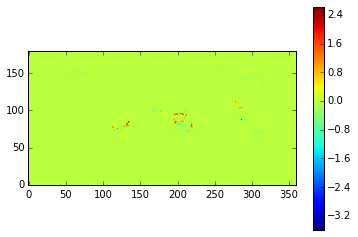

In [12]:
sibcasa_gfas_diff = (bb_yravg_sibcasa_mean - bb_yravg_gfas_mean)
sibcasa_finn_diff = (bb_yravg_sibcasa_mean - bb_yravg_finn_mean)
sibcasa_casa_diff = (bb_yravg_sibcasa_mean - bb_yravg_casa_mean)

imshow(sibcasa_gfas_diff)
colorbar()
plt.gca().invert_yaxis()

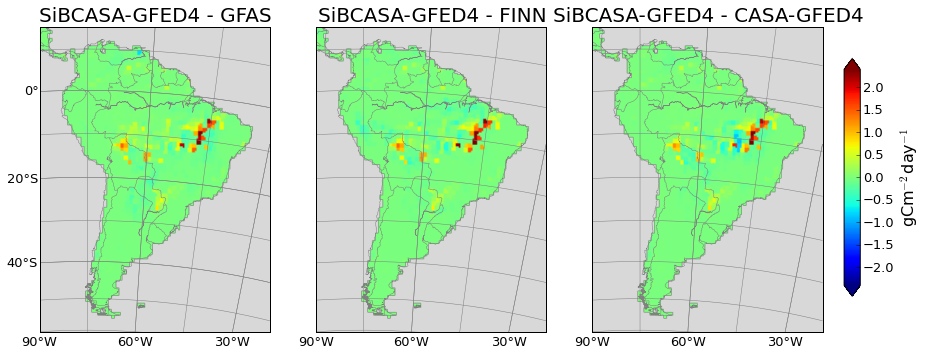

In [19]:
fig = plt.figure(1,figsize=(15,10))

ax1 = plt.subplot2grid((1, 3), (0, 0), colspan=1)
ax1.set_title('SiBCASA-GFED4 - GFAS',fontsize=20)
m,nx,ny = make_map()
m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=13)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=13)
fluxmap = m.transform_scalar((sibcasa_gfas_diff*tc),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap(),vmin=-2.4,vmax=2.4)

ax2 = plt.subplot2grid((1, 3), (0, 1), colspan=1)
ax2.set_title('SiBCASA-GFED4 - FINN',fontsize=20)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=13)
fluxmap = m.transform_scalar((sibcasa_finn_diff*tc),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap(),vmin=-2.4,vmax=2.4)

ax3 = plt.subplot2grid((1, 3), (0, 2), colspan=1)
ax3.set_title('SiBCASA-GFED4 - CASA-GFED4',fontsize=20)
m,nx,ny = make_map()
#m.drawparallels(np.arange(-40,10,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0],fontsize=11)
m.drawmeridians(np.arange(-180,180,30),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1],fontsize=13)
fluxmap = m.transform_scalar((sibcasa_casa_diff*tc),lons,lats,nx,ny,order=0)
q = m.imshow(fluxmap,cmap=get_cmap(),vmin=-2.4,vmax=2.4)

fig.subplots_adjust(right=0.85,top=0.9,wspace=0.2,hspace=0.05)
cbar_ax = fig.add_axes([0.87, 0.35, 0.015, 0.33]) # left, bottom, width, height
cbar = fig.colorbar(q, cax=cbar_ax, extend='both')
cbar.ax.tick_params(labelsize=13)
cbar.set_label(r'gCm$^{-2}$day$^{-1}$', fontsize = 16)
fig.savefig('SpatialDistribution_Subtracts.png',bbox_inches='tight',DPI=1000)
plt.show()
plt.close()

In [14]:
#Importing CASA biomes
ff='/Users/botia/biomecomparison/Landcover2.csv'
biomesmap=[]

with open(ff,'rb') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    for row in csvreader:
        biomesmap.append([float(item) for item in row]) 
        
biomesmap = np.array(biomesmap)
biomesmap = biomesmap[::-1]
biomes_casa_1x1 = np.zeros((180,360),float)

for i in range(180):
    for j in range(360):
        lst = biomesmap[i+i:(i+1)*2,j+j:(j+1)*2].flatten().tolist()
        biomes_casa_1x1[i,j] = max(set(lst), key=lst.count)
        
biomes_casa_1x1 = np.ma.masked_where(biomes_casa_1x1 == 0,biomes_casa_1x1)

# Importing SiBCASA Biomes
f = cdf.Dataset('/Storage/CO2/carbontracker/input/ctdas_2012/regions_sibcasa.nc') 
biomes_sib= f.variables['land_ecosystems'][:]  
f.close() 
#imshow(biomes_casa_1x1)
#colorbar()
#plt.gca().invert_yaxis()

######################################Both biome maps are masked at the ocean

In [15]:
casa_coord    = np.zeros((180,360),float)
sibcasa_coord = np.zeros((180,360),float)
for i in range(180):
    for j in range(360):
        if sibcasa_casa[i][j] > 0.7: 
            casa_coord[i][j] = biomes_casa_1x1[i][j]
            sibcasa_coord[i][j] = biomes_sib[i][j]
            
casa_coord = np.ma.masked_where(casa_coord == 0,casa_coord)
sibcasa_coord = np.ma.masked_where(sibcasa_coord == 0,sibcasa_coord)

/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


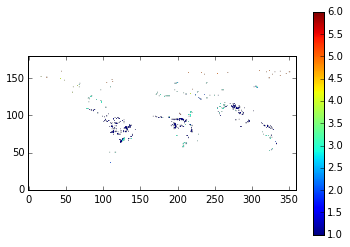

In [16]:
#imshow(casa_coord)
imshow(sibcasa_coord)
colorbar()
plt.gca().invert_yaxis()

In [17]:
number_biomes = [] 
for i in range(180):
    for j in range(360):
        if not (casa_coord*tc)[i][j] is ma.masked:
            number_biomes.append(casa_coord[i][j]) 
print set(number_biomes)

set([9.0, 2.0, 6.0, 7.0])


In [18]:
biomes_casa_anom = ['Evergreen broadleaf forest',   #2 = Tall Broadleaf Evergeen Trees
                   'Shrublands',                   #6 = Short broadleaf shrubs with bare soil
                   'Savanna and grasslands',       #7 = Grasslands
                   'Croplands',                    #9 = Agriculture
                   ]     

clrs_casa_mod     = ['green',         #2
                    'brown',         #6
                    'lawngreen',     #7
                    'darkslateblue', #9
                    ]           

In [19]:
number_biomes = [] 
for i in range(180):
    for j in range(360):
        if not (sibcasa_coord*tc)[i][j] is ma.masked:
            number_biomes.append(sibcasa_coord[i][j]) 
print set(number_biomes)

set([1.0, 2.0, 3.0])


In [20]:
biomes_sib_anom = ['Tall Broadleaf-Evergreen Trees',         #1
                   'Tall Broadleaf-Deciduous Trees',         #2
                   'Tall Broadleaf and Needleleaf Trees',    #3
                   ] 

clrs_sib = ['green',        #1
           'magenta',       #2
           'orange',        #3
           ] 

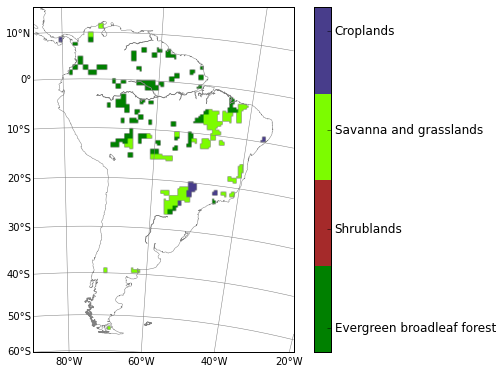

In [21]:
from matplotlib import colors
from mpl_toolkits.basemap import Basemap

lons=np.arange(-179.5,180,1)
lats=np.arange(-89.5,90,1)

clrs = clrs_casa_mod
plotmap = casa_coord

labels = ['Evergreen broadleaf forest', 'Shrublands',                   
          'Savanna and grasslands', 'Croplands' ]

maxnr = len(labels)
#savename = 'Casa_biome_amazon_map.png'

fig     = plt.figure(figsize=(8,6))
ax      = fig.add_axes([0.05,0.1,0.7,0.8])
m,nx,ny = select_map('South America Albers')
fluxmap = m.transform_scalar((plotmap),lons,lats,nx,ny,order=0)
#bounds=np.arange(-0.5,maxnr+0.5,1)
ticks =np.arange(0,maxnr+1,1)
m.drawcoastlines(color='grey',linewidth=0.5)
m.drawparallels(np.arange(-60,30,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,0,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1])
cmap = mpl.colors.ListedColormap(clrs)
im=m.imshow(fluxmap,cmap=cmap)
#bounds=np.arange(0.5,maxnr+0.5,1)
#bounds=np.arange(0,10,0.2)
ticks = np.arange(2.5,9.8,2)
#divider = make_axes_locatable(ax)
#cax = divider.append_axes("right", size="4%", pad=0.2)
#cbar=plt.colorbar(im,boundaries=bounds,ticks=ticks,cax=cax)
cbar=plt.colorbar(im,ticks=ticks)#,boundaries=bounds,ticks=ticks)#,cax=cax)
cbar.ax.set_yticklabels(labels,va='center',fontsize=12)
#fig.savefig(savename)
plt.show()


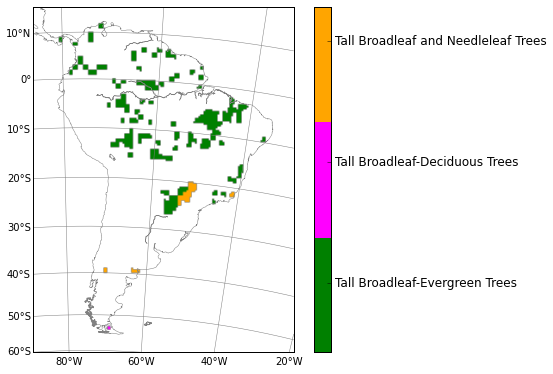

In [163]:
lons=np.arange(-179.5,180,1)
lats=np.arange(-89.5,90,1)

clrs = ['green',         #1
        'magenta',       #2
        'orange']        #3

labels = ['Tall Broadleaf-Evergreen Trees',         #1
          'Tall Broadleaf-Deciduous Trees',         #2
          'Tall Broadleaf and Needleleaf Trees',    #3
         ] 

maxnr = len(labels)
plotmap = sibcasa_coord

fig     = plt.figure(figsize=(8,6))
ax      = fig.add_axes([0.05,0.1,0.7,0.8])
m,nx,ny = select_map('South America Albers')
fluxmap = m.transform_scalar((plotmap),lons,lats,nx,ny,order=0)
#bounds=np.arange(-0.5,maxnr+0.5,1)
ticks =np.arange(0,maxnr+1,0.7)
m.drawcoastlines(color='grey',linewidth=0.5)
m.drawparallels(np.arange(-60,30,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,0,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1])
cmap = mpl.colors.ListedColormap(clrs)
im=m.imshow(fluxmap,cmap=cmap)
#ticks = np.arange(2.5,9.8,1.5)
cbar=plt.colorbar(im,ticks=ticks)#,boundaries=bounds,ticks=ticks)#,cax=cax)
cbar.ax.set_yticklabels(labels,va='center',fontsize=12)
#fig.savefig(savename)
plt.show()



In [171]:
check = np.zeros((180,360),float)
for i in range(180):
    for j in range(360):
        if biomes_sib[i][j] == 1:
            check[i][j] = biomes_sib[i][j]
check = np.ma.masked_where(check == 0,check)

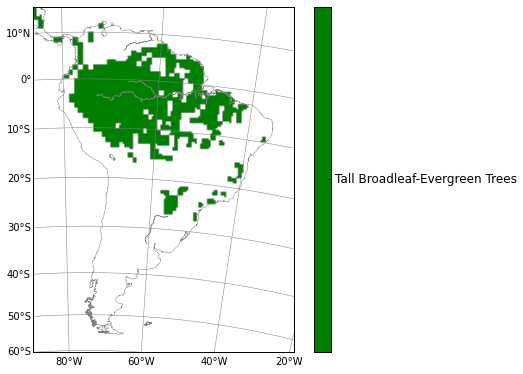

In [172]:
lons=np.arange(-179.5,180,1)
lats=np.arange(-89.5,90,1)

clrs = ['green']        

labels = ['Tall Broadleaf-Evergreen Trees'] 

maxnr = len(labels)
plotmap = check

fig     = plt.figure(figsize=(8,6))
ax      = fig.add_axes([0.05,0.1,0.7,0.8])
m,nx,ny = select_map('South America Albers')
fluxmap = m.transform_scalar((plotmap*tc),lons,lats,nx,ny,order=0)
#bounds=np.arange(-0.5,maxnr+0.5,1)
ticks =np.arange(0,maxnr+1,1)
m.drawcoastlines(color='grey',linewidth=0.5)
m.drawparallels(np.arange(-60,30,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,0,20),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1])
cmap = mpl.colors.ListedColormap(clrs)
im=m.imshow(fluxmap,cmap=cmap)
#ticks = np.arange(2.5,9.8,1.5)
cbar=plt.colorbar(im,ticks=ticks)#,boundaries=bounds,ticks=ticks)#,cax=cax)
cbar.ax.set_yticklabels(labels,va='center',fontsize=12)
#fig.savefig(savename)
plt.show()

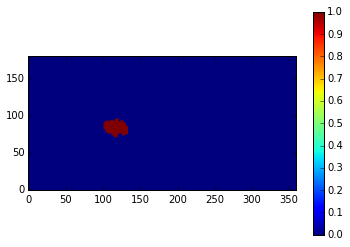

In [10]:
imshow(mask)
colorbar()
plt.gca().invert_yaxis()

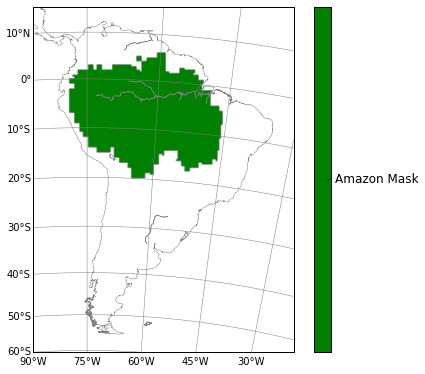

In [19]:
lons=np.arange(-179.5,180,1)
lats=np.arange(-89.5,90,1)
mask1 = np.ma.masked_where(mask == 0,mask)
clrs = ['green']        

labels = ['Amazon Mask'] 

maxnr = len(labels)
plotmap = mask1

fig     = plt.figure(figsize=(8,6))
ax      = fig.add_axes([0.05,0.1,0.7,0.8])
m,nx,ny = select_map('South America Albers')
fluxmap = m.transform_scalar((plotmap),lons,lats,nx,ny,order=0)
#bounds=np.arange(-0.5,maxnr+0.5,1)
ticks =np.arange(0,maxnr+1,1)
m.drawcoastlines(color='grey',linewidth=0.5)
m.drawparallels(np.arange(-60,30,10),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[1,0,0,0])
m.drawmeridians(np.arange(-120,0,15),color='grey',linewidth=0.5,dashes=[1,0.0001],labels=[0,0,0,1])
cmap = mpl.colors.ListedColormap(clrs)
im=m.imshow(fluxmap,cmap=cmap)
#ticks = np.arange(2.5,9.8,1.5)
cbar=plt.colorbar(im,ticks=ticks)#,boundaries=bounds,ticks=ticks)#,cax=cax)
cbar.ax.set_yticklabels(labels,va='center',fontsize=12)
#fig.savefig(savename)
plt.show()